In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import matplotlib.patches as mpatches

import spacy

D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [2]:
pd.set_option('display.max_rows', 200_000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2_500)

In [3]:
nlp = spacy.load('pt')

D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
nlp.max_length = 3_000_000

Antes de começar as análises com os tweets, vamos dar uma olhada nos dados do Datafolha sobre os presidenciáveis até então. Fonte: https://www.poder360.com.br/banco-de-dados/

In [5]:
datafolha_est = pd.read_csv('datafolha_est.csv')
datafolha_rej = pd.read_csv('datafolha_rej.csv')

datafolha_est['data_pesquisa'] = datafolha_est['data_pesquisa'].apply(lambda x: pd.Timestamp(x).date())
datafolha_rej['data_pesquisa'] = datafolha_rej['data_pesquisa'].apply(lambda x: pd.Timestamp(x).date())

### Dados intenção de votos aos presidenciáveis
***

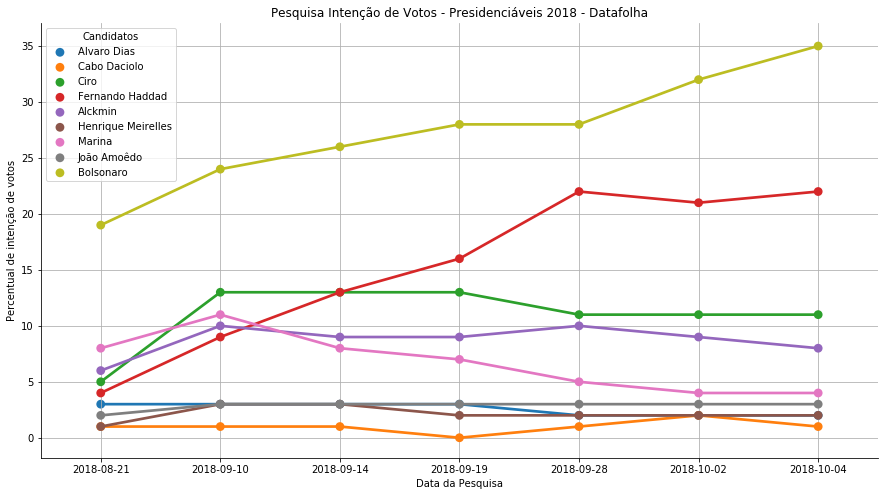

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = sns.pointplot(x='data_pesquisa',
                  y='percentual',
                  hue='candidato',
                  data=datafolha_est,
                  hue_order=['Alvaro Dias', 'Cabo Daciolo', 'Ciro', 'Fernando Haddad', 'Alckmin', 'Henrique Meirelles',
                             'Marina', 'João Amoêdo', 'Bolsonaro'],
                  ax=ax)

_ = ax.set(title='Pesquisa Intenção de Votos - Presidenciáveis 2018 - Datafolha',
           xlabel='Data da Pesquisa',
           ylabel='Percentual de intenção de votos')

_ = sns.despine()
_ = ax.grid(True)
_ = ax.legend(title='Candidatos')

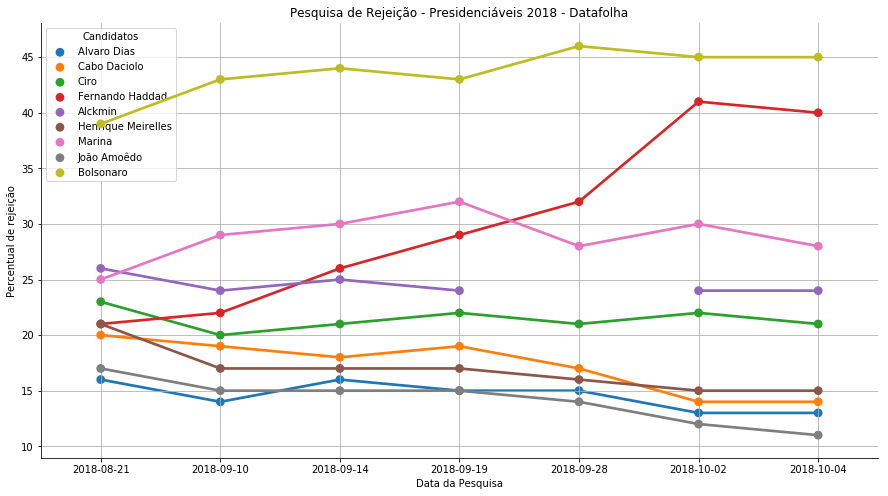

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = sns.pointplot(x='data_pesquisa',
                  y='percentual',
                  hue='candidato',
                  data=datafolha_rej,
                  hue_order=['Alvaro Dias', 'Cabo Daciolo', 'Ciro', 'Fernando Haddad', 'Alckmin', 'Henrique Meirelles',
                             'Marina', 'João Amoêdo', 'Bolsonaro'],
                  ax=ax)

_ = ax.set(title='Pesquisa de Rejeição - Presidenciáveis 2018 - Datafolha',
           xlabel='Data da Pesquisa',
           ylabel='Percentual de rejeição')

_ = sns.despine()
_ = ax.grid(True)
_ = ax.legend(title='Candidatos')

## Dados twitter durante o debate
***

In [8]:
tweets = pd.read_csv('../tweets_debate_globo_limpo.csv')

tweets.head()

,text,datetime,text_clean
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix
2,Boulos: A\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição
3,"O microfone do Meirelles caiu agora.\r\n\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30
4,"PROPOSTAS DE BOLSONARO\r\n- Fim do 13º e férias\r\n- Redução da licença maternidade\r\n- IR igual pra ricos e POBRES\r\n- Volta da CPMF\r\n- Fim do Bolsa Família e projetos sociais\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\n- Mais armas em circulação\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação


In [9]:
tweets['datetime'] = tweets['datetime'].apply(pd.Timestamp)

In [10]:
tweets['hour'] = tweets['datetime'].apply(lambda x: x.hour)
tweets['minute'] = tweets['datetime'].apply(lambda x: x.minute)

In [11]:
tweets.head()

,text,datetime,text_clean,hour,minute
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho,22,42
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix,23,17
2,Boulos: A\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição,23,19
3,"O microfone do Meirelles caiu agora.\r\n\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30,22,27
4,"PROPOSTAS DE BOLSONARO\r\n- Fim do 13º e férias\r\n- Redução da licença maternidade\r\n- IR igual pra ricos e POBRES\r\n- Volta da CPMF\r\n- Fim do Bolsa Família e projetos sociais\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\n- Mais armas em circulação\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação,22,31


In [12]:
tweets.shape

(508503, 5)

In [47]:
candidatos = ['alvaro', 'ciro', 'haddad', 'alckmin', 'meirelles', 'marina', 'bolsonaro']
display_candidatos = ['Álvaro Dias', 'Ciro Gomes', 'Fernando Haddad', 'Geraldo Alckmin', 'Henrique Meirelles', 'Marina Silva', 'Jair Bolsonaro']
colors = ['blue', 'green', 'red', 'purple', 'brown', 'pink', 'goldenrod']
map_names = {k: v for k, v in zip(candidatos, display_candidatos)}

{'alvaro': 'Álvaro Dias',
 'ciro': 'Ciro Gomes',
 'haddad': 'Fernando Haddad',
 'alckmin': 'Geraldo Alckmin',
 'meirelles': 'Henrique Meirelles',
 'marina': 'Marina Silva',
 'bolsonaro': 'Jair Bolsonaro'}

In [52]:
import re
from collections import Counter

def localizar_palavra(palavra, dataset): 
    return pd.Series(np.histogram([word.i for word in dataset if word.text.lower() == palavra], bins=50)[0])

def is_word_in_text(word, text):
    pattern = r'(^|[^\w]){}([^\w]|$)'.format(word)
    pattern = re.compile(pattern, re.IGNORECASE)
    matches = re.search(pattern, text)
    return bool(matches)

def plot_contagem_candidatos(df, lista_candidatos):
    contagem = []
    for candidato in lista_candidatos:
        contagem.append(df['text'].astype(str).apply(lambda x: is_word_in_text(candidato, x.lower())).sum())

    plot_df = pd.DataFrame({'Candidatos': candidatos, 'Contagem': contagem}).sort_values(by='Contagem', ascending=False)
    plot_df['Candidatos'] = plot_df['Candidatos'].map(map_names)
    fig, ax = plt.subplots(figsize=(15, 8))
    _ = sns.barplot(x='Candidatos', y='Contagem', data=plot_df, ax=ax)
    _ = sns.despine()

def verbs_candidates(text, candidate):
    sents = [sent for sent in text.sents if candidate in sent.string.lower()]
    char_words = []
    for sent in sents: 
        for word in sent: 
            if candidate in word.string: 
                char_words.append(word)
    char_verbs = []
    for word in char_words: 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                char_verbs.append(ancestor.lemma_.strip())
    return Counter(char_verbs).most_common(5)

def frases_candidato_verbo(df, candidato, verbo, qtde=5):
    mask_cand = df['text_clean'].astype(str).apply(lambda x: is_word_in_text(candidato, x))
    mask_verb = df['text_clean'].astype(str).apply(lambda x: is_word_in_text(verbo, x))
    return list(data_1[mask_cand & mask_verb]['text'].head(qtde))

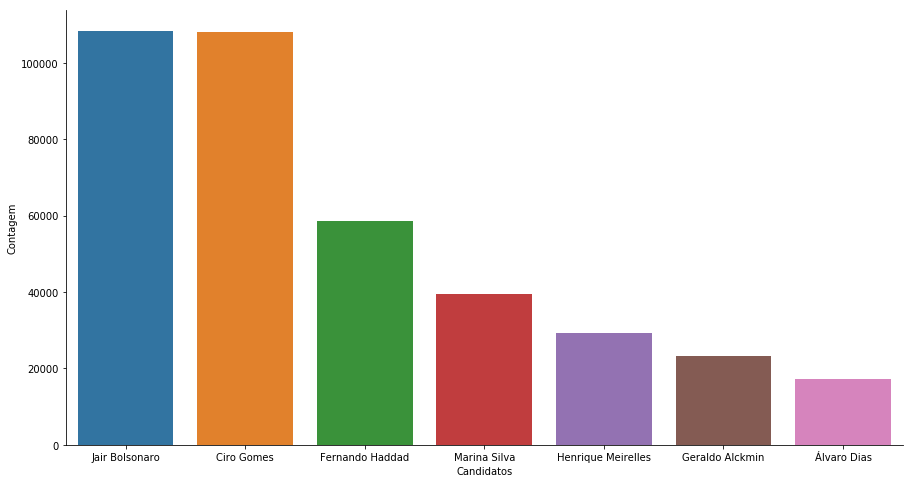

In [53]:
plot_contagem_candidatos(tweets, candidatos)

- Distribuição dos tweets na primeira hora de debate:

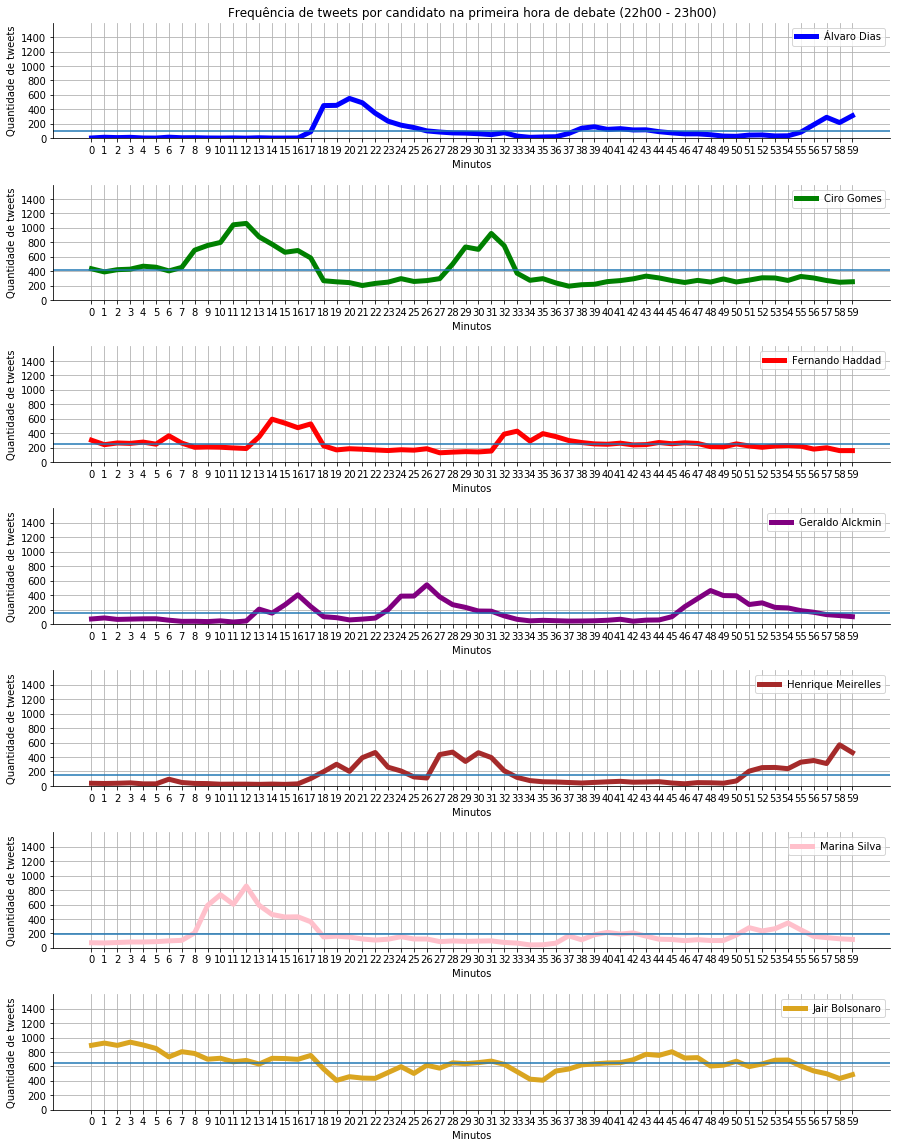

In [40]:
fig, axes = plt.subplots(7, 1, figsize=(15, 20))

df_hour = tweets[tweets['hour']==22]
indexes = list(range(0, 8))
for idx, candidato, c, nome in zip(indexes, candidatos, colors, display_candidatos):
    to_plot = df_hour[df_hour['text'].apply(lambda x: is_word_in_text(candidato, x))]['minute'].value_counts().sort_index().reset_index()
    _ = sns.lineplot(x='index', y='minute', data=to_plot, ax=axes[idx], color=c, label=nome, linewidth=5)

    _ = axes[idx].set(xlabel='Minutos',
                      ylabel='Quantidade de tweets',
                      xticks=list(range(0, 60, 1)),
                      yticks=list(range(0, 1_500, 200)),
                      ylim=[0, 1_600])
           
    _ = axes[idx].legend()
    _ = axes[idx].grid(True)
    _ = axes[idx].axhline(to_plot['minute'].mean())

_ = sns.despine()
_ = axes[0].set_title('Frequência de tweets por candidato na primeira hora de debate (22h00 - 23h00)')
_ = plt.subplots_adjust(hspace=0.4)
_ = plt.show()

- Distribuição dos tweets na segunda hora de debate

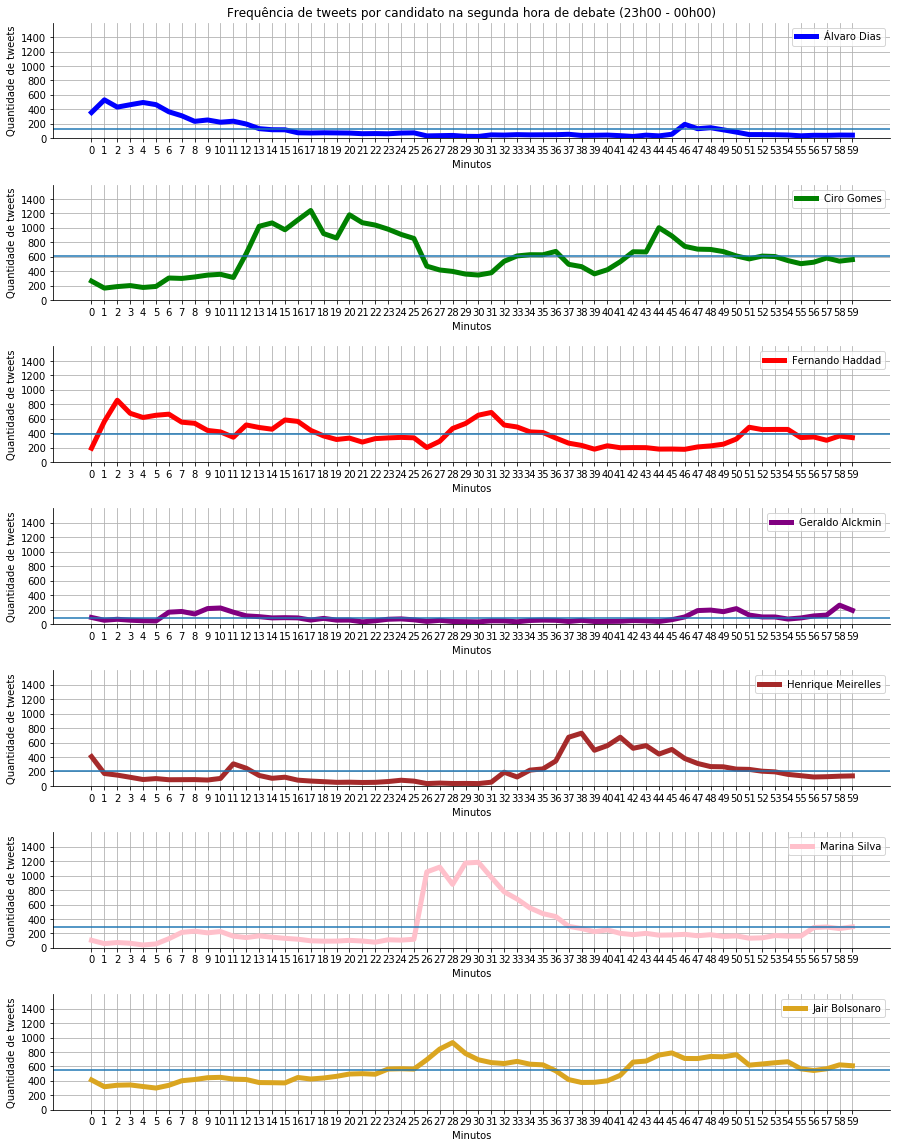

In [41]:
fig, axes = plt.subplots(7, 1, figsize=(15, 20))

df_hour = tweets[tweets['hour']==23]
indexes = list(range(0, 8))
for idx, candidato, c, nome in zip(indexes, candidatos, colors, display_candidatos):
    to_plot = df_hour[df_hour['text'].apply(lambda x: is_word_in_text(candidato, x))]['minute'].value_counts().sort_index().reset_index()
    _ = sns.lineplot(x='index', y='minute', data=to_plot, ax=axes[idx], color=c, label=nome, linewidth=5)

    _ = axes[idx].set(xlabel='Minutos',
                      ylabel='Quantidade de tweets',
                      xticks=list(range(0, 60, 1)),
                      yticks=list(range(0, 1_500, 200)),
                      ylim=[0, 1_600])
           
    _ = axes[idx].legend()
    _ = axes[idx].grid(True)
    _ = axes[idx].axhline(to_plot['minute'].mean())

_ = sns.despine()
_ = axes[0].set_title('Frequência de tweets por candidato na segunda hora de debate (23h00 - 00h00)')
_ = plt.subplots_adjust(hspace=0.4)
_ = plt.show()

- Distribuição dos tweets na terceira hora de debate

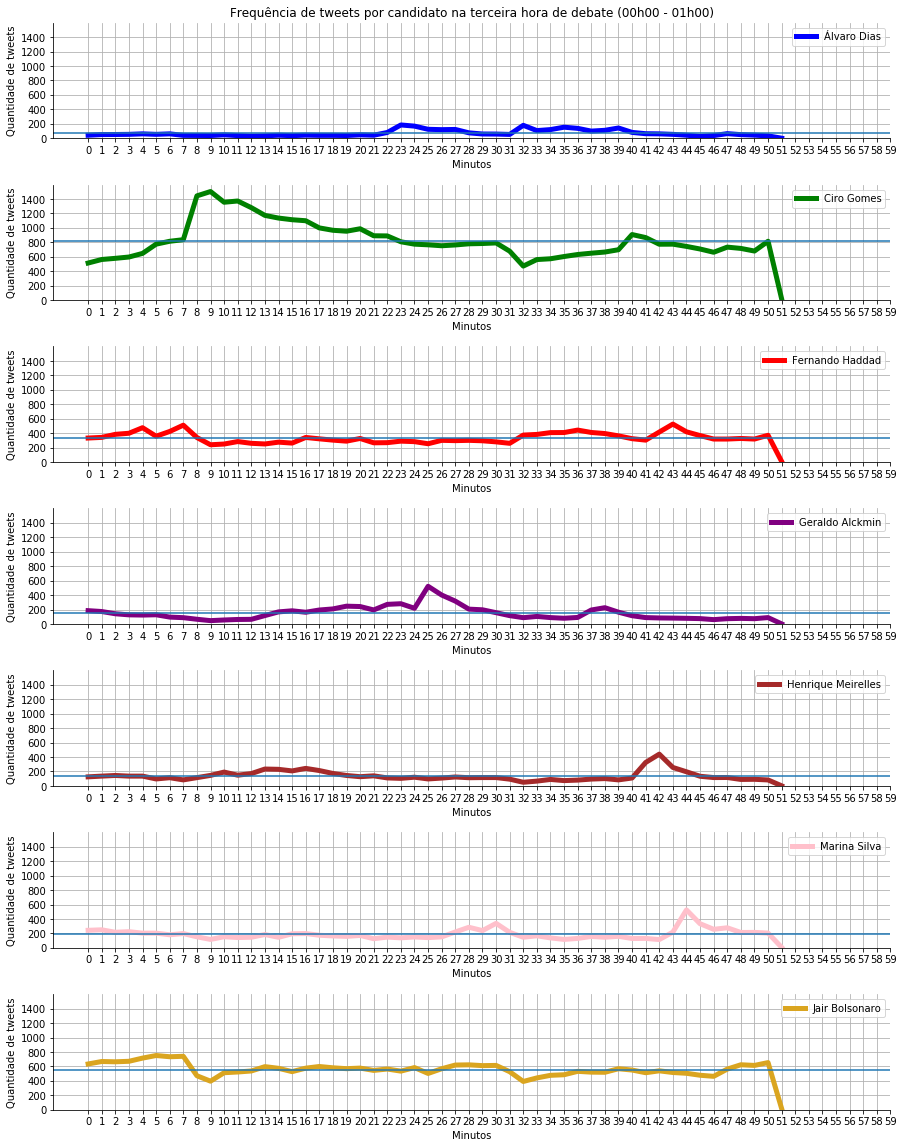

In [42]:
fig, axes = plt.subplots(7, 1, figsize=(15, 20))

df_hour = tweets[tweets['hour']==0]
indexes = list(range(0, 8))
for idx, candidato, c, nome in zip(indexes, candidatos, colors, display_candidatos):
    to_plot = df_hour[df_hour['text'].apply(lambda x: is_word_in_text(candidato, x))]['minute'].value_counts().sort_index().reset_index()
    _ = sns.lineplot(x='index', y='minute', data=to_plot, ax=axes[idx], color=c, label=nome, linewidth=5)

    _ = axes[idx].set(xlabel='Minutos',
                      ylabel='Quantidade de tweets',
                      xticks=list(range(0, 60, 1)),
                      yticks=list(range(0, 1_500, 200)),
                      ylim=[0, 1_600])
           
    _ = axes[idx].legend()
    _ = axes[idx].grid(True)
    _ = axes[idx].axhline(to_plot['minute'].mean())

_ = sns.despine()
_ = axes[0].set_title('Frequência de tweets por candidato na terceira hora de debate (00h00 - 01h00)')
_ = plt.subplots_adjust(hspace=0.4)
_ = plt.show()